In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report as report
import matplotlib.pyplot as plt
data="process.csv"

In [27]:
import multiprocessing

max_cores = multiprocessing.cpu_count()
print(f"Maximum number of CPU cores: {max_cores}")

Maximum number of CPU cores: 4


In [3]:
df = pd.read_csv(data)
df = df.fillna(-2)
df.head()


,Shape,formula_pretty,formula_anonymous,volume,density,density_atomic,energy_per_atom,band_gap,efermi,is_gap_direct,is_metal,is_magnetic,ordering,total_magnetization,theoretical
0,5,Sr2Ca2Mn(FeO4)3,AB2C2D3E12,464.619079,4.788145,11.615477,-7.326006,0.0000,2.939687,0,1,1,1,32.160904,1
1,0,Sr3BiSb,ABC3,240.278399,4.102311,48.055680,-3.138934,0.0000,2.141091,0,1,0,0,0.000600,1
2,0,Ce3AlC,ABC3,124.050388,6.148731,24.810078,-6.384508,0.0000,7.126619,0,1,1,1,2.546990,0
3,0,ZnNi3N,ABC3,51.770561,8.195023,10.354112,-5.608232,0.0000,6.683385,0,1,0,0,0.000003,1
4,0,Rb2LiNdCl6,ABC2D6,302.124895,2.939569,30.212490,-4.410963,4.8504,-0.985833,1,0,0,0,0.000016,1


In [4]:
features=['volume', 'density', 'density_atomic', 'energy_per_atom','band_gap', 'efermi','is_gap_direct', 'is_metal', 'is_magnetic', 'ordering','total_magnetization','theoretical']  
X = df.loc[0:len(df), features].values
Y = df.loc[0:len(df), "Shape"].values

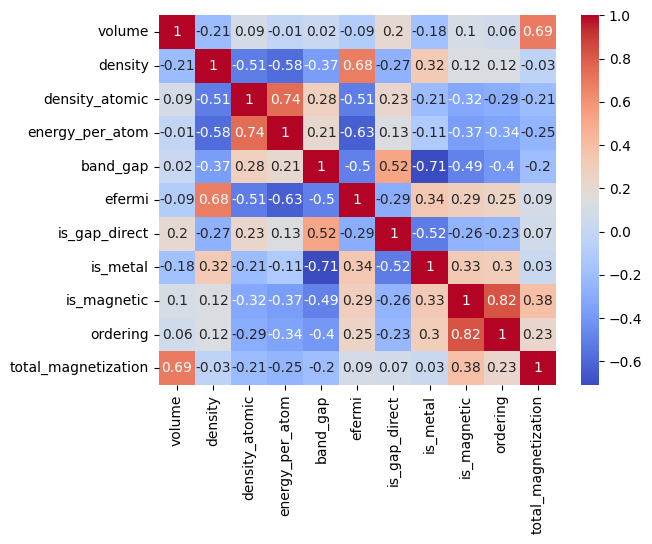

In [41]:
df_sub=df[features[:len(features)-1]]
corr_matrix = df_sub.corr()
corr_matrix = corr_matrix.round(2)

import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

In [5]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split (X, Y, test_size=0.15, random_state=42)
print(len(X_train),len(X_test))
oversample = SMOTE()#oversampling of data
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

6673 1178


In [6]:
def CRandCM(method,X_test,Y_test):#a function to print classification report and confusion matrix
    Y_pred=method.predict(X_test)
    cr = report(Y_test,  Y_pred)
    cm = confusion_matrix(Y_test, Y_pred)
    print(cr)
    print(cm)

Random Forests


In [29]:
from sklearn.metrics import roc_auc_score
best_params_={'n_estimators': 250,'criterion': 'entropy',
 'max_depth': 100,
 'min_samples_split': 2
 }

In [30]:
rfc = RandomForestClassifier(n_estimators=250,max_depth=100,min_samples_split=2,criterion='entropy')
rfc.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=250)

In [31]:
import numpy as np


In [10]:
y_pred_proba = rfc.predict_proba(X_test)
roc_auc_scores = []
for i in range(Y_train.min(), Y_train.max()+1):
    y_true_i = (Y_test == i).astype(int)
    roc_auc_scores.append(roc_auc_score(y_true_i, y_pred_proba[:, i]))

# Calculate the mean AOC ROC curve score across all classes
mean_roc_auc = np.mean(roc_auc_scores)
print(roc_auc_scores)


[0.9960213146172174, 0.992031243508247, 0.9841570466570467, 0.966998844598498, 0.9998765279664156, 0.9872247964606404, 0.9981809375168182]


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

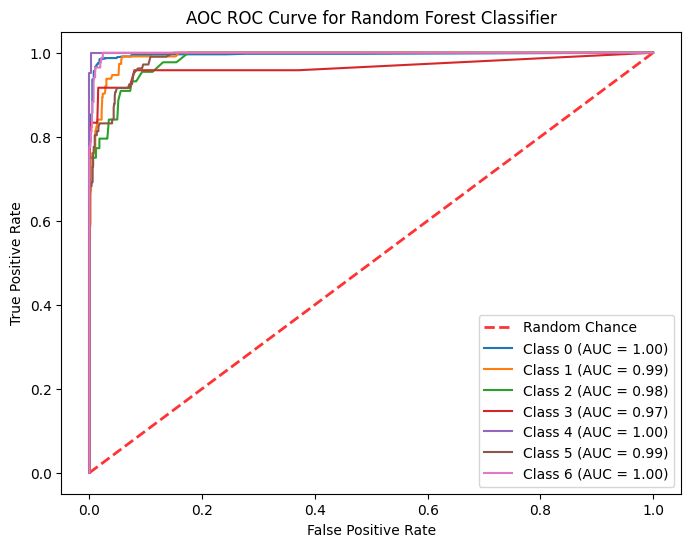

In [12]:
fprs = []
tprs = []
roc_auc_scores = []
for i in range(Y_train.min(), Y_train.max()+1):
    y_true_i = (Y_test == i).astype(int)
    fpr, tpr, _ = roc_curve(y_true_i, y_pred_proba[:, i])
    fprs.append(fpr)
    tprs.append(tpr)
    roc_auc_scores.append(roc_auc_score(y_true_i, y_pred_proba[:, i]))

mean_roc_auc = np.mean(roc_auc_scores)
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Chance', alpha=.8)

for i in range(Y_train.min(), Y_train.max()+1):
    plt.plot(fprs[i], tprs[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc_scores[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AOC ROC Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

In [13]:
accuracy = rfc.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9439728353140917


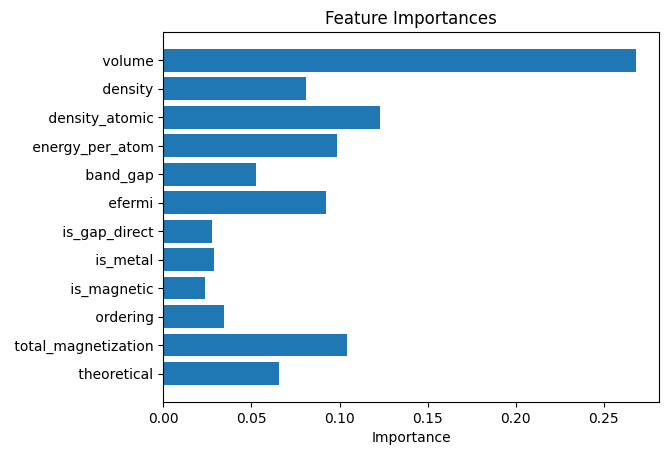

In [50]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]
ig, ax = plt.subplots()
y_pos = np.arange(len(importances))
ax.barh(y_pos, importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels([" {}".format(features[i]) for i in range(len(importances))])
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Feature Importances')

plt.show()

Multilayer Perception

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

hidden_layer_sizes_range = [(10,), (50,), (100,)]
alpha_range = [0.0001, 0.001, 0.01]
learning_rate_range = ['constant', 'adaptive']
param_grid = dict(hidden_layer_sizes=hidden_layer_sizes_range,
                  alpha=alpha_range,
                  learning_rate=learning_rate_range)
mlp = MLPClassifier()
grid = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, Y_train)

print("Best parameters: ", grid.best_params_)
print("Best accuracy score: ", grid.best_score_)

c:\Users\sunil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sunil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sunil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sunil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Best parameters:  {'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Best accuracy score:  0.6500272316484641


In [14]:
mlp = MLPClassifier(alpha=0.01,hidden_layer_sizes=(100,),learning_rate='constant')
mlp.fit(X_train,Y_train)
accuracy = mlp.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6808149405772496


In [46]:
weights = mlp.coefs_[0]

# Calculate the feature importances based on the weights
importances = np.mean(np.abs(weights), axis=1)

# Print the feature importances
print("Feature importances:")
for i, importance in enumerate(importances):
    print("{}: {:.4f}".format(features[i], importance))

Feature importances:
volume: 0.0306
density: 0.0996
density_atomic: 0.0773
energy_per_atom: 0.1047
band_gap: 0.1397
efermi: 0.1433
is_gap_direct: 0.2785
is_metal: 0.2066
is_magnetic: 0.2395
ordering: 0.1743
total_magnetization: 0.0807
theoretical: 0.3329


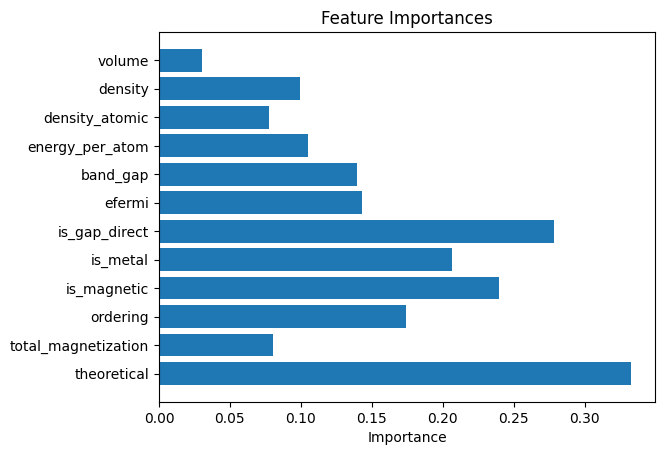

In [48]:
fig, ax = plt.subplots()
y_pos = np.arange(len(importances))
ax.barh(y_pos, importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(["{}".format(features[i]) for i in range(len(importances))])
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Feature Importances')

plt.show()

Recurrent Neural Networks (RNN)

In [17]:
from sklearn.neural_network import MLPRegressor

In [18]:
model = MLPRegressor(hidden_layer_sizes=(32,), activation='relu', solver='adam', max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, Y_train)
accuracy = model.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.48857654915350923


Quadratic Discriminant Analysis (QDA)

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [11]:
model = QuadraticDiscriminantAnalysis()

# Train the model
model.fit(X_train, Y_train)

# Evaluate the model on the testing set
accuracy = model.score(X_test, Y_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.58
